In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Discover community structure using `igraph` and `leidenalg`

See also: <https://arxiv.org/abs/1810.08473>

In [2]:
import igraph as ig
import leidenalg as la

Create a graph based on the Zachary karate club, a famous example used in network science: 

In [3]:
G = ig.Graph.Famous("Zachary")

Find a partition, i.e., detect communities with modularity, then plot using `python-igraph` and `cairocffi`:

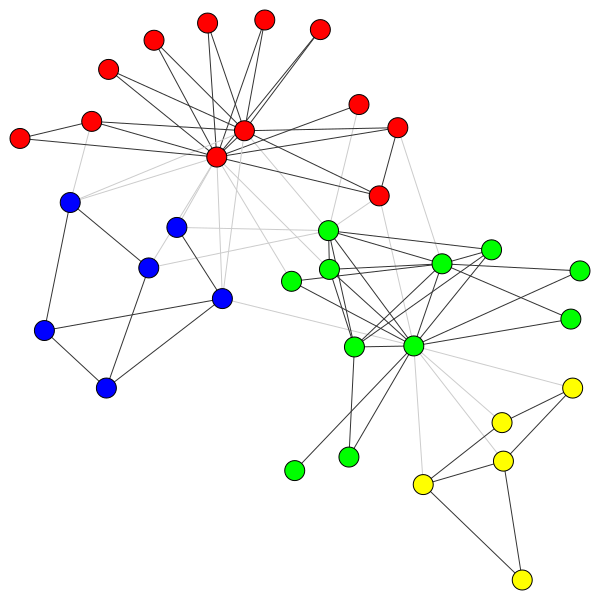

In [4]:
partition = la.find_partition(G, la.ModularityVertexPartition)
ig.plot(partition)

---

## Integration with `kglab`

In [5]:
import kglab

namespaces = {
    "nom":  "http://example.org/#",
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    }

kg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    namespaces = namespaces,
    )

kg.load_rdf("../dat/recipes.ttl")

In [6]:
measure = kglab.Measure()
measure.measure_graph(kg)
subgraph = kglab.Subgraph(kg)

keyset = measure.get_keyset(incl_pred=False)
len(keyset)

286

In [7]:
G = ig.Graph()
G.add_vertices(n=keyset)

In [8]:
sparql = """
    SELECT ?recipe ?ingredient
    WHERE {
        ?recipe rdf:type wtm:Recipe .
        ?recipe wtm:hasIngredient ?ingredient .
    }
    """

In [9]:
for row in kg.query(sparql):
    s_id = subgraph.transform(row.recipe)
    s_label = subgraph.get_name(row.recipe)

    o_id = subgraph.transform(row.ingredient)
    o_label = subgraph.get_name(row.ingredient)

    G.add_edges([ (s_id, o_id,) ])

G.vs["label"] = G.vs["name"]

In [10]:
G.vs[0].attributes()

{'name': 'http://example.org/#Batter', 'label': 'http://example.org/#Batter'}

In [11]:
with open("tmp.graphml", "w") as f:
    G.write_graphml(f)

## Community detection

In [12]:
component = G.components().subgraph(0)
partition = la.find_partition(component, la.ModularityVertexPartition)

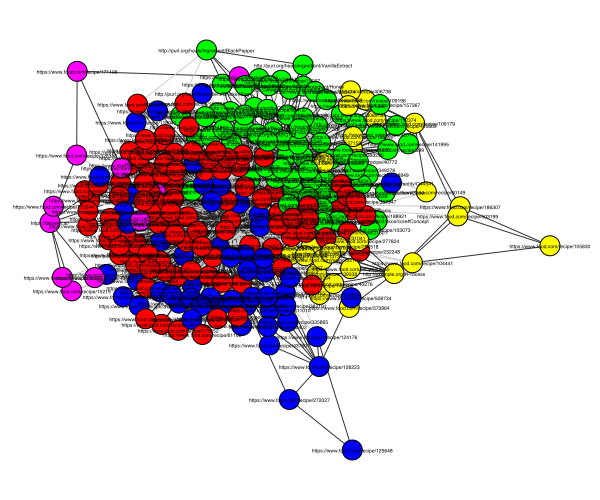

In [13]:
ig.plot(partition, bbox=(600, 500), vertex_label_size=5, margin=50)

Let's look into the community that involves `ind:Butter`, `nom:Pancake`, etc.

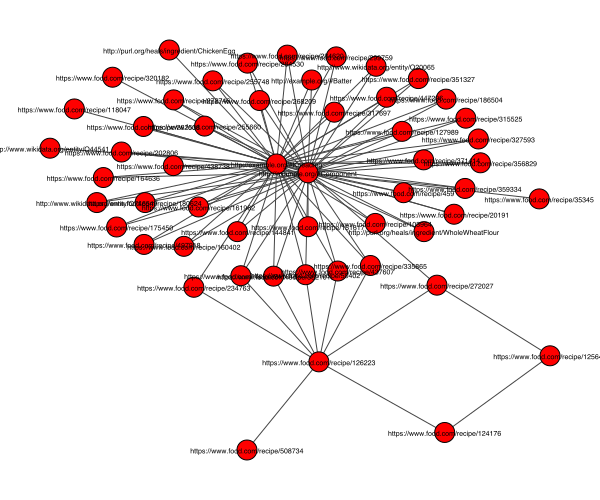

In [14]:
ig.plot(partition.subgraph(2), bbox=(600, 500), vertex_label_size=7, margin=50)